In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

FOLDERNAME = 'Colab\ Notebooks/DeepFool-master/Python'
assert FOLDERNAME is not None, "[!] Enter the foldername."

%cd drive/MyDrive/$FOLDERNAME

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/DeepFool-master/Python


In [2]:
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.utils.data as data_utils
from torch.autograd import Variable
import math
import torchvision.models as models
from PIL import Image
from deepfool import deepfool
import os

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


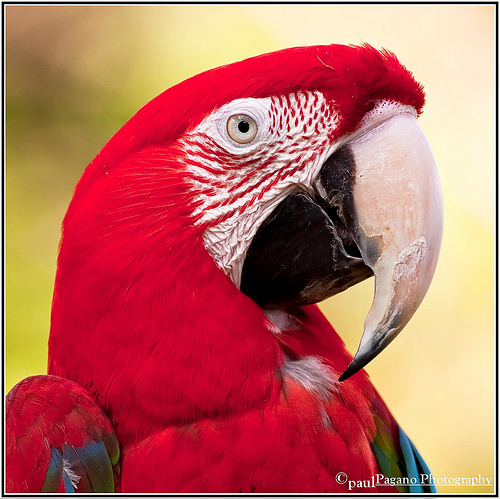

In [3]:
net = models.resnet34(pretrained=True)

# Switch to evaluation mode
net.eval()

im_orig = Image.open('test_im1.jpg')
# im_orig = Image.open('dog.jpg')
im_orig.show()
#print(im_orig)
mean = [ 0.485, 0.456, 0.406 ]
std = [ 0.229, 0.224, 0.225 ]

In [4]:
# Remove the mean
preprocess_fn = transforms.Compose([
        transforms.Resize((256,256)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])
im = preprocess_fn(im_orig)
# im = transforms.Compose([
#     #transforms.Scale(256),
#     transforms.Resize((256, 256)),
#     transforms.CenterCrop(224),
#     transforms.ToTensor(),
#     transforms.Normalize(mean = mean,
#                          std = std)])(im_orig)

In [5]:
r, loop_i, label_orig, label_pert, pert_image, output_list, orig_confidence, adv_confidence, pert_tensor = deepfool(im, net)

labels = open(os.path.join('synset_words.txt'), 'r').read().split('\n')

str_label_orig = labels[np.int(label_orig)].split(',')[0]
str_label_pert = labels[np.int(label_pert)].split(',')[0]

# for i in range(len(output_list)):
#   print(f"loop{i}: predict {labels[np.int(output_list[i])].split(',')[0]}")

print("Original label = ", str_label_orig, ", prob :", orig_confidence)
print("Perturbed label = ", str_label_pert, ", prob:", adv_confidence)

Using CPU
Original label =  n01818515 macaw , prob : 1.0
Perturbed label =  n02007558 flamingo , prob: 0.4834


<ipython-input-5-d2c5262ecd97>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  str_label_orig = labels[np.int(label_orig)].split(',')[0]
<ipython-input-5-d2c5262ecd97>:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated

In [6]:
def inverse_preprocess(x):
    t = x.squeeze(0)

    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    t = t.mul(torch.FloatTensor(std).view(3,1,1)).add(torch.FloatTensor(mean).view(3,1,1)) #.numpy()

    im = transforms.ToPILImage()(t) #.convert("RGB") #.Resize((299, 299))

    return im

In [7]:
import matplotlib.pyplot as plt

def plot(x, x_adv, x_grad, x_label, x_prob, x_adv_label, x_adv_prob):

    # figure, ax = plt.subplots(1,3, figsize=(18,8))
    figure, ax = plt.subplots(1,3, figsize=(12,8))
    ax[0].imshow(x)
    ax[0].set_title('Original', fontsize=16)

    ax[1].imshow(x_grad)
    ax[1].set_title('Perturbation', fontsize=16)
    ax[1].set_yticklabels([])
    ax[1].set_xticklabels([])
    ax[1].set_xticks([])
    ax[1].set_yticks([])

    ax[2].imshow(x_adv)
    ax[2].set_title('New', fontsize=16)

    ax[0].axis('off')
    ax[2].axis('off')

    ax[0].text(0.5,-0.13, "Prediction: {}\n Probability: {:.0%}".format(x_label, x_prob), size=12, ha="center",
               transform=ax[0].transAxes)

    ax[1].text(1.1,0.5, " = ", size=15, ha="center", transform=ax[1].transAxes)

    ax[2].text(0.5,-0.13, "Prediction: {}\n Probability: {:.0%}".format(x_adv_label, x_adv_prob), size=12, ha="center",
               transform=ax[2].transAxes)


    plt.show()

test torch.Size([1, 3, 256, 256])


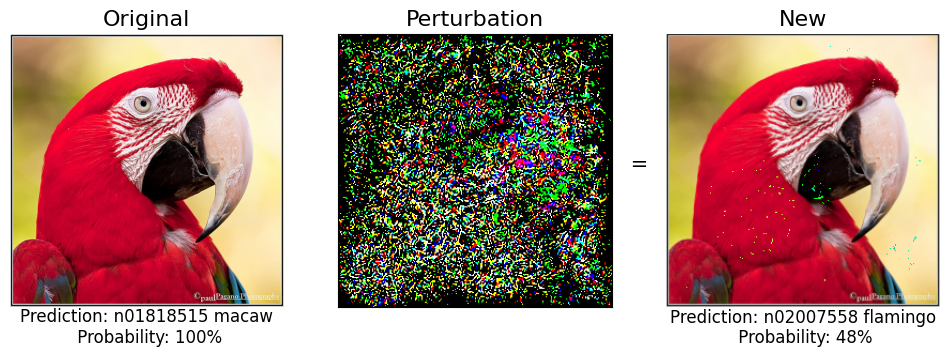

In [8]:
img_adv = inverse_preprocess(pert_image)
#img_adv.show()
# r_image = inverse_preprocess(torch.FloatTensor(r))
print("test", pert_tensor.shape)
a = pert_image - im
b = a.squeeze(0)
pert_diff = transforms.ToPILImage()(b)
# pert_diff = inverse_preprocess(a)
#r_image.show()
plot(im_orig, img_adv, pert_diff, str_label_orig, orig_confidence, str_label_pert, adv_confidence)
# print(pert_image.shape)
#img_avd = transforms.ToPILImage()(pert_image)

In [9]:
# a = np.array((1,2,-2,3))
# c = np.array(([1, 3], [2, -4]))
# c[0, 1]
#a
#a[:-1]
#a.argsort()
#b = a[::-1] # reverse array a


In [10]:
# # m = [3, 5] = [x1, x2]
# m = Variable(torch.FloatTensor([[3, 5]]), requires_grad=True)
# n = Variable(torch.zeros(1, 2))
# print("m:", m)
# # n = [x1**2 + x2**3]
# n[0, 0] = m[0, 0] ** 2
# n[0, 1] = m[0, 1] ** 3
# print("n:", n)
# # m.grad.data.zero_()
# print("n.grad:", n.grad)
# print("m.grad:", m.grad)
# a = torch.FloatTensor([[1, 1]])
# print("n[0, 0].shape", n[0, 0].shape)
# n[0 ,0].backward(a[0, 0], retain_graph=True) # n = [2*x1, 3*x2**2]
# print("m.grad:", m.grad)

# m.grad.data.zero_()
# n[0 ,1].backward(a[0, 1]) # n = [2*x1, 3*x2**2]

# # m.grad.data.zero_()
# print("m.grad:", m.grad)

In [11]:
# def clip_tensor(A, minv, maxv):
#     A = torch.max(A, minv*torch.ones(A.shape))
#     A = torch.min(A, maxv*torch.ones(A.shape))
#     return A

In [12]:
# clip = lambda x: clip_tensor(x, 0, 255)

# # tf = transforms.Compose([transforms.Normalize(mean=[0, 0, 0], std=map(lambda x: 1 / x, std)),
# #                         transforms.Normalize(mean=map(lambda x: -x, mean), std=[1, 1, 1]),
# #                         transforms.Lambda(clip),
# #                         transforms.ToPILImage(),
# #                         transforms.CenterCrop(224)])
# tf = transforms.Compose([transforms.Normalize(mean=mean, std=std),
#                         transforms.Lambda(clip),
#                         transforms.ToPILImage(),
#                         transforms.CenterCrop(224)])


In [13]:
# plt.figure()
# plt.imshow(tf(pert_image.cpu()[0]))
# plt.title(str_label_pert)
# plt.show()